In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2024-06-13 16:47:24.378822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 16:47:25.349565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available. Using GPU.")
else:
    print("No GPU available. Using CPU.")

Num GPUs Available:  0
No GPU available. Using CPU.


2024-06-13 16:47:26.189941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 16:47:26.190627: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Path of the dataset
data_dir = "Data/"

# Label map for categoriues
categories = ['Parasitized', 'Uninfected']
label_map = {categories: index for index, categories in enumerate(categories)}

In [5]:
# List for file path and corresponding labels

file_path = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path.append(os.path.join(category_path, filename))
            labels.append(label_map[category])

In [6]:
# Converting file and labels to tensorflow datasets
file_path = tf.convert_to_tensor(file_path, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

In [7]:
# Creation of dataset from file path and labels?
dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(file_path), seed=42)

In [8]:
dataset_size = len(file_path)
print(f"Dataset Size: {dataset_size}")

train_ratio = int(0.6 * dataset_size)
val_ratio = int(0.2 * dataset_size)
test_ratio = dataset_size - train_ratio - val_ratio

Dataset Size: 27558


In [9]:
train_dataset = dataset.take(train_ratio)
val_dataset = dataset.skip(train_ratio).take(val_ratio)
test_dataset = dataset.skip(train_ratio).skip(val_ratio)

In [10]:
print(f"train size: {len(train_dataset)}")
print(f"val size: {len(val_dataset)}")
print(f"test size: {len(test_dataset)}")

train size: 16534
val size: 5511
test size: 5513


In [11]:
for image, label in train_dataset.take(1):
    print("Image type:", type(image))
    print("Image:", image)
    print("Label:", label.numpy())

Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Image: tf.Tensor(b'Data/Uninfected/C123P84ThinF_IMG_20151002_151432_cell_129.png', shape=(), dtype=string)
Label: 1


2024-06-13 16:47:26.894634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-06-13 16:47:27.297116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


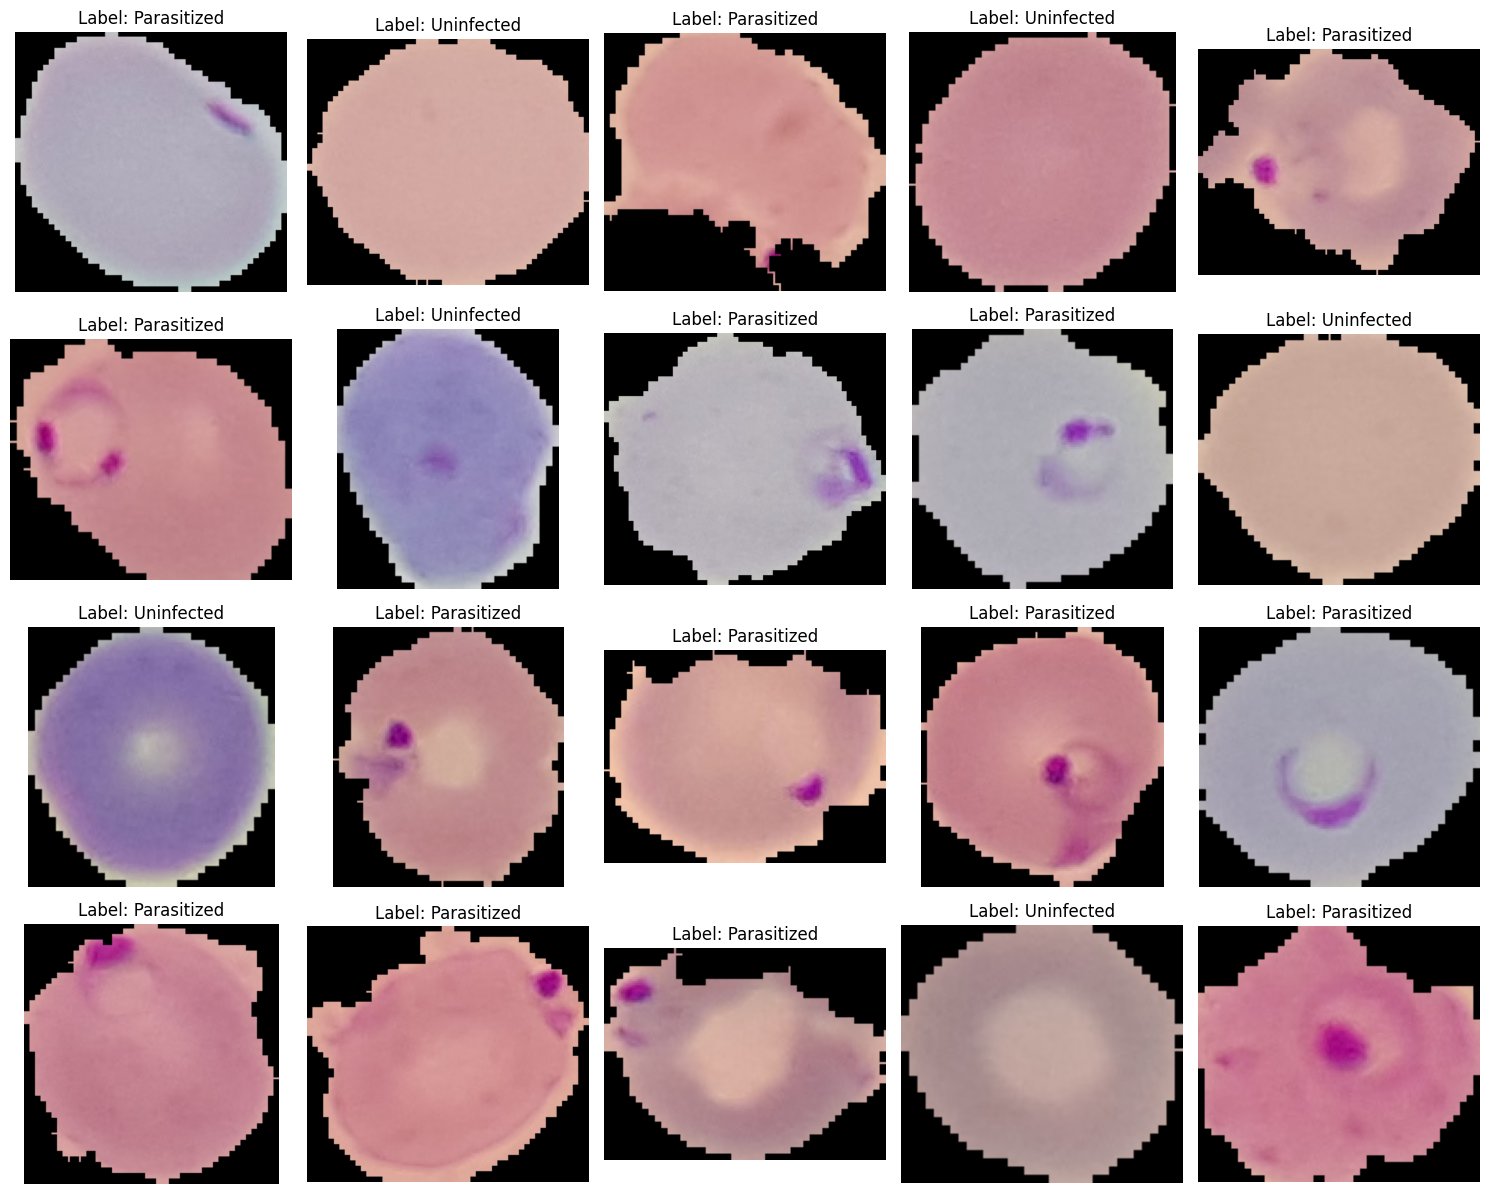

In [12]:
def load_and_preprocess_image(file_path):
    # Read the image file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_png(img, channels=3)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Plotting some images from the train dataset
plt.figure(figsize=(15, 15))
for i, (file_path, label) in enumerate(val_dataset.take(20)):
    ax = plt.subplot(5, 5, i + 1)
    
    # Load and preprocess the image
    image = load_and_preprocess_image(file_path)
    
    plt.imshow(image)
    plt.title(f"Label: {categories[label.numpy()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Function to load and preprocess images
def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])  # Ensure shape is known
    image = tf.image.resize(image, [224, 224])  # Resize to a fixed size if needed
    image = image / 255.0  # Normalize to [0, 1] range
    return image, label

In [14]:
# Apply the load_image function to the dataset
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-06-13 16:47:29.184884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


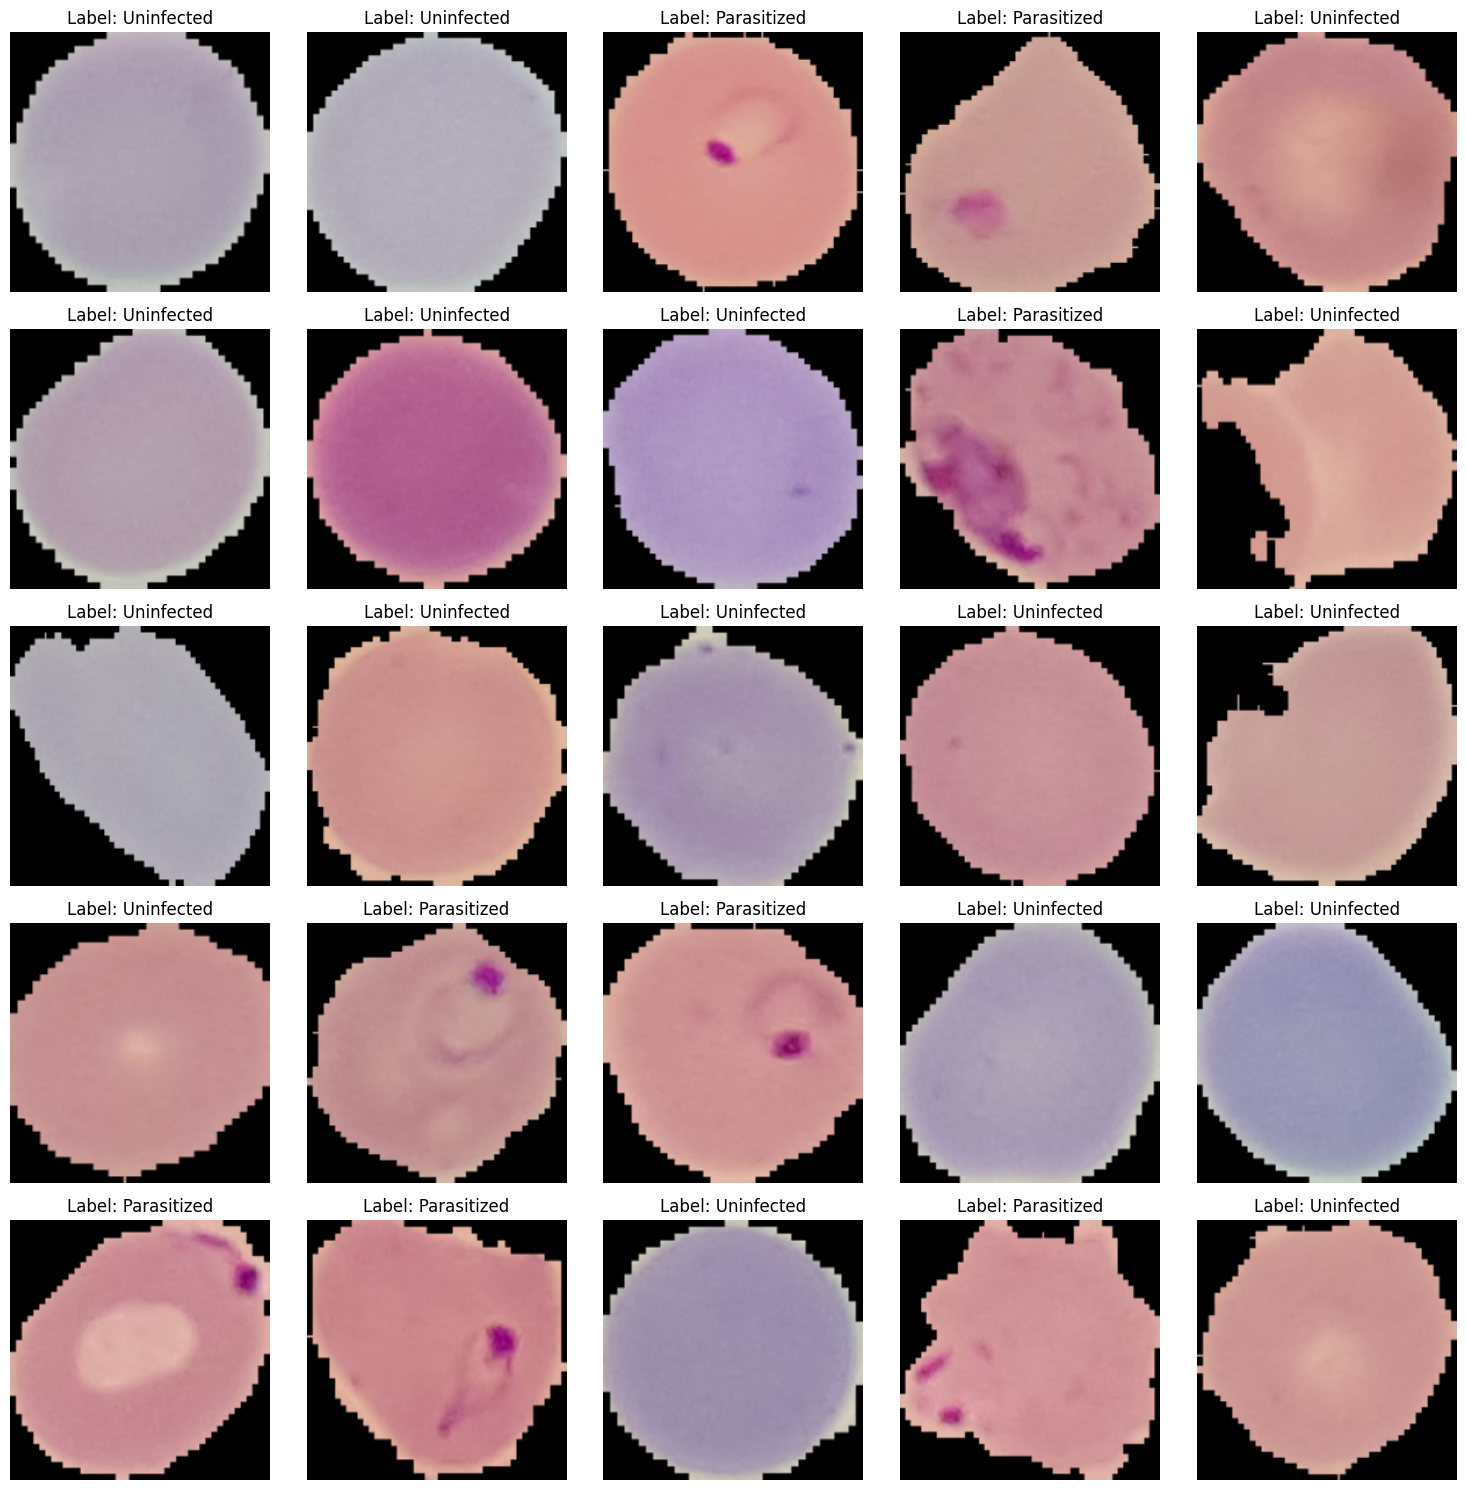

In [16]:
# Function to load and preprocess image for plotting
def load_and_preprocess_image(file_path):
    # Convert file_path to string if it's a tensor
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')
    
    # Read the image file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_png(img, channels=3)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Plotting some images from the train dataset
plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(train_dataset.unbatch().take(25)):
    ax = plt.subplot(5, 5, i + 1)
    
    plt.imshow(image.numpy())
    plt.title(f"Label: {categories[label.numpy()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras import models, layers

def create_resnet_model(input_shape=(224, 224, 3), num_classes=2):
    def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
        shortcut = x
        if conv_shortcut:
            shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([shortcut, x])
        x = layers.ReLU()(x)
        
        return x
    
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [18]:
# Create and compile the model
with tf.device('/GPU:0'):  # Force the model to be created on GPU
    model = create_resnet_model(input_shape=(224, 224, 3))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [19]:
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 11,459,010 (43.71 MB)

 Trainable params: 11,449,282 (43.68 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [20]:
# Train the model
with tf.device('/GPU:0'):  # Force training on GPU
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
        ]
    )

Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1689s 3s/step - accuracy: 0.7381 - loss: 0.5964 - val_accuracy: 0.5157 - val_loss: 0.9064 - learning_rate: 0.0010
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1491s 3s/step - accuracy: 0.9516 - loss: 0.1488 - val_accuracy: 0.9292 - val_loss: 0.2945 - learning_rate: 0.0010
Epoch 3/50
160/517 ━━━━━━━━━━━━━━━━━━━━ 19:02 3s/step - accuracy: 0.9607 - loss: 0.1265

NameError: name 'history' is not defined

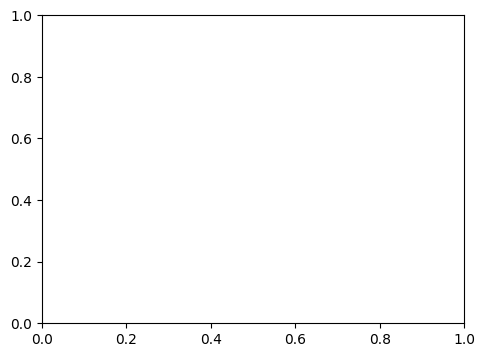

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on validation set
val_loss, val_acc = model.evaluate(val_dataset)
print(f'Validation accuracy: {val_acc:.4f}')

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
# Save the model
model.save('parasitized_cell_classifier.h5')
print("Model saved successfully.")

In [ ]:
# To demonstrate how to load the model:
loaded_model = tf.keras.models.load_model('parasitized_cell_classifier.h5')
print("Model loaded successfully.")

In [ ]:
# Visualize the architecture of the loaded model

loaded_model.summary()

In [ ]:
# Verify that the loaded model has the same test accuracy
test_loss, test_acc = loaded_model.evaluate(test_dataset)
print(f'Loaded model - Test accuracy: {test_acc:.4f}')